#### BlackJack - Random Selection of an Action

The implemenation is done for Random action selection. Here the agen performs only exploration

Imports all the packages required


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random

Defines all the constants neccesary in the implementation for easy access of the data

In [2]:
# Define constants

# suits
SPADES = "spades"
HEARTS = "hearts"
DIAMONDS = "diamonds"
CLUBS = "clubs"
# values
TWO = "2"
THREE = "3"
FOUR = "4"
FIVE = "5"
SIX = "6"
SEVEN = "7"
EIGHT = "8"
NINE = "9"
TEN = "10"
JACK = "jack"
QUEEN = "queen"
KING = "king"
ACE = "ace"

# ace values
ACE_HIGH_VALUE = 11
ACE_LOW_VALUE = 1

# Rewards
DRAW_REWARD = 0
WIN_REWARD = 1
LOSE_REWARD = -1
DOUBLE_DOWN_WIN_REWARD = 2
DOUBLE_DOWN_LOSE_REWARD = -2
WIN_BLACKJACK_REWARD = 10
WIN_BLACKJACK_REWARD_6_TO_5 = 12
INVALID_ACTION_REWARD = -3
VALID_ACTION_REWARD = 3


# actions
HIT = "hit"
STAND = "stand"
DOUBLE_DOWN = "double_down"
SPLIT = "split"
ACTIONS = [HIT,STAND,DOUBLE_DOWN,SPLIT]
HARD_HAND = "hard"
SOFT_HAND = "soft"

# card counting categories
HIGH_CARDS = [TEN, JACK, QUEEN, KING, ACE]
LOW_CARDS = [TWO, THREE, FOUR, FIVE, SIX]
NEUTRAL_CARDS = [SEVEN, EIGHT, NINE]

This class `Blackjack (object)` defines the blackjack environment all the neccessary rules and actions

In [59]:
class Blackjack (object):
    def __init__ (self) :
        self.deck = self.create_deck()
        self.player_card = []
        self.dealer_card = []
        self.has_ace = False
        self.end_game = False
        self.reward = 0
        self.split_flag = False
        self.newgame = self.reset()
    
    
    def create_deck(self) :
        suits = [SPADES,DIAMONDS,HEARTS,CLUBS]
        ranks = [TWO,THREE,FOUR,FIVE,SIX,SEVEN,EIGHT,NINE,TEN,JACK,QUEEN,KING,ACE]
        deck = list(itertools.product(ranks,suits))
        random.shuffle(deck)
        return deck
        
    def get_card(self) :
        top_card = self.deck.pop()
        if(len(top_card) == 0) :
            top_card = self.create_deck().pop()
        
        return top_card
    
    def calculate_card_value(self, card):
        value = 0
        for card , suit in card :
           # print(f'cards :{card}')
            if str(card).lower() in [JACK,QUEEN,KING] :
                 value+=10
            elif str(card).isnumeric() :
                value+=int(card)
            
            if self.has_ace : 
                if (value + 11 ) >= 21 :
                    value += ACE_LOW_VALUE
                else :
                    value+= ACE_HIGH_VALUE
        return value 
    
    def reset(self) :
        #Re-initialisation for starting new game or episode 
        self.deck = self.create_deck()
        self.player_card = [self.get_card(),self.get_card()]
        self.dealer_card = [self.get_card(),self.get_card()]
        self.has_ace = self.contains_ace(self.player_card)
        self.split_flag = True if (len(self.player_card) == 2 and self.player_card[0][0] == self.player_card[1][0]) else False
        self.end_game = False
        return self.state_status()

    def state_status(self):
        player_card_value = self.calculate_card_value(self.player_card)
        dealer_first_card = self.dealer_card[0]
        self.split_flag = True if (len(self.player_card) == 2 and self.player_card[0][0] == self.player_card[1][0]) else False
        return player_card_value,dealer_first_card,self.has_ace,self.split_flag
    
    def contains_ace(self,player_card) : 
        for card , suit in player_card :
            if card.casefold() == ACE.casefold() :
                return True
        return False


    def step(self,action) :
        if len(self.player_card) == 2 and len(self.dealer_card) == 2 :
            state_status, self.reward, end_game = self.check_for_blackjack()
            if end_game :
                return state_status,self.reward, end_game
        
        # Hit / Stand
        if action.lower() == HIT :
            self.player_card.append(self.get_card())
            player_card_value = self.calculate_card_value(self.player_card)
            if(player_card_value > 21) :
                #print("Player Lost / busted ")
                self.end_game = True
                self.reward = LOSE_REWARD
                return self.state_status(),self.reward,self.end_game
            else : 
                self.reward = 0
        elif action.lower() == STAND :
            #End of players turn, begin dealers turn
            self.end_game = True
            dealer_card_value = self.calculate_card_value(self.dealer_card)
            while (dealer_card_value < 17 ) :
                self.dealer_card.append(self.get_card())
                dealer_card_value = self.calculate_card_value(self.dealer_card)
            
            self.reward = self.winner_or_loser()
    
        elif action.lower() == DOUBLE_DOWN :
            #End of players turn, begin dealers turn
            self.player_card.append(self.get_card())
            self.end_game = True
            dealer_card_value = self.calculate_card_value(self.dealer_card)
            while (dealer_card_value < 17 ) :
                self.dealer_card.append(self.get_card())
                dealer_card_value = self.calculate_card_value(self.dealer_card)
            
            self.reward = self.winner_or_loser()
        
        elif action.lower() == SPLIT :
            self.split_pairs()
        return self.state_status(),self.reward,self.end_game 
     
    def split_pairs(self):
        rewards = []
        player_new_card_1 = self.get_card()
        player_new_card_2 = self.get_card()
        player_hand_1 = [self.player_card[0], player_new_card_1]
        player_hand_2 = [self.player_card[1], player_new_card_2]
        player_hands = [player_hand_1, player_hand_2]
        self.player_card.append(player_new_card_1)
        self.player_card.append(player_new_card_2)
       
        for hand in player_hands:
            hand_card_numbers = []
            self.player_card = hand  # Set current hand to be played
            self.has_ace = self.contains_ace(hand)
            
            for p_card in hand :
                hand_card_numbers.append(p_card[0]) 
                
            player_card_value = self.calculate_card_value(hand)
            if(player_card_value > 21) :
                self.reward = LOSE_REWARD
            else : 
                self.reward = 0
                
            rewards.append(self.reward)
        self.end_game = True
        # Determine final rewards based on the outcome of both hands
        if all(reward > 0 for reward in rewards):
            # Both hands win
            self.reward = sum(rewards)  # Add rewards for both winning hands
        elif all(reward < 0 for reward in rewards):
            # Both hands lose
            self.reward = sum(rewards)  # Sum of negative rewards is negative
        else:
            # One hand wins and one hand loses
            self.reward = sum(rewards)  # Net reward
        
        return self.state_status(),self.reward,self.end_game 
   
    def winner_or_loser(self) : 
        player_card_value = self.calculate_card_value(self.player_card)
        dealer_card_value = self.calculate_card_value(self.dealer_card)
        if player_card_value  > 21 :
            return LOSE_REWARD #player busted
        elif dealer_card_value > 21 :
            return WIN_REWARD #Player wins dealer busted
        elif player_card_value > dealer_card_value :
            return WIN_REWARD # Player wins
        elif player_card_value < dealer_card_value : 
            return LOSE_REWARD #Player lost dealer won
        else : 
            return DRAW_REWARD #its draw
        
    def check_for_blackjack(self) :
        player_card_value = self.calculate_card_value(self.player_card)
        dealer_card_value = self.calculate_card_value(self.dealer_card)
        if player_card_value  == 21 and dealer_card_value == 21:
            self.end_game = True
            self.reward = DRAW_REWARD
        elif player_card_value == 21 :
            self.end_game = True
            self.reward = WIN_BLACKJACK_REWARD
        return self.state_status(),self.reward,self.end_game   

This calss `BlackjackAgent` defines the implementation of  Qlearning agent. Here there is no q_table update as the agent focuses only on explorationa and not exploitation

In [76]:
class BlackjackAgent:
    def __init__(self, alpha, gamma, epsilon, epsilon_decay, final_epsilon):
        self.actions = ACTIONS
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.q_table = {}

    def select_action(self, current_state):
        if current_state not in self.q_table:
            self.q_table[current_state] = np.zeros(len(self.actions))
        if current_state[3] : 
            action = SPLIT
        else : 
            action = random.choice([HIT,STAND,DOUBLE_DOWN])
        return action

    def update_q_table(self, current_state, action, reward, next_state):
        if current_state not in self.q_table:
            self.q_table[current_state] = np.zeros(len(self.actions))
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(len(self.actions))
        index_of_action = self.actions.index(action)
        known_q_value = self.q_table[current_state][index_of_action]
        predicted_q_value = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[current_state][index_of_action] += self.alpha * (predicted_q_value - known_q_value)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

The task is tested with 1000000 episode and results are evaluated

In [107]:
def evaluate(num_episodes,alpha, gamma, epsilon, epsilon_decay, final_epsilon):
    play_game = Blackjack()
    blackjack_agent = BlackjackAgent(alpha, gamma, epsilon, epsilon_decay, final_epsilon)
    wins = 0
    losses = 0
    draws = 0
    episode_rewards = []
    average_rewards = []

    for episode in range(num_episodes):
        current_state = play_game.reset()
        end_game = False
        episode_reward = 0

        while not end_game:
            current_action = blackjack_agent.select_action(current_state)
            next_state, reward, end_game = play_game.step(current_action,)
            current_state = next_state
            episode_reward += reward
        
        episode_rewards.append(episode_reward)

        if episode_reward > 0:
            wins += 1
        elif episode_reward == 0:
            draws += 1
        else:
            losses += 1

        if (episode + 1) % 1000 == 0:
            average_reward = sum(episode_rewards[-1000:]) / 1000
            average_rewards.append(average_reward)
            
    win_rate = wins / num_episodes
    loss_rate = losses / num_episodes
    draw_rate = draws / num_episodes
    
    print(f"Average reward: {sum(episode_rewards)/num_episodes:.2f}")
    print(f"Number of wins: {wins}, Win rate: {win_rate}")
    print(f"Number of losses: {losses}, Loss rate: {loss_rate}")
    print(f"Number of draws: {draws}, Draw rate: {draw_rate}")


    return episode_rewards, average_rewards, win_rate, loss_rate, draw_rate


In [116]:
alpha = 0 # learning rate
gamma = 0.8  # discount factor
epsilon =  1  # initial epsilon for exploration
num_episodes = 1000000
final_epsilon = 1
epsilon_decay = 0 

episode_rewards, average_rewards, win_rate, loss_rate, draw_rate = evaluate(num_episodes,alpha, gamma, epsilon, epsilon_decay, final_epsilon)


Average reward: -0.28
Number of wins: 265295, Win rate: 0.265295
Number of losses: 645959, Loss rate: 0.645959
Number of draws: 88746, Draw rate: 0.088746


A graph is plotted to understand the average reward structure

In [117]:
def plot_rewards(average_rewards):
    episodes_per_chunk = 1000
    num_chunks = len(average_rewards)
    total_episodes = num_chunks * episodes_per_chunk

    # Plotting the learning curve (average reward per episode)
    plt.figure(figsize=(4, 3))
    plt.plot(np.arange(1, total_episodes + 1, episodes_per_chunk), average_rewards, label='Average Reward')
    plt.title('Average Reward per 1000 Episode ')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

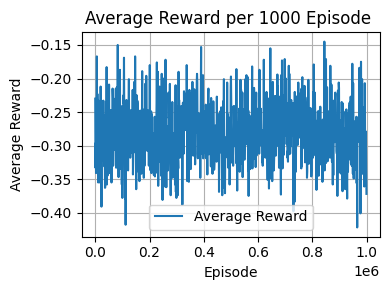

In [118]:
plot_rewards(average_rewards)

Name : Preeti Venkataraman Hegde

Matriculation Id : 5123764

Email : preetivenkataraman.hegde@study.thws.de